In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

In [2]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
print(element_list)
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        spectrum = file["Edep (noise)"].values()
        #spectrum = file["Edep"].values()

        # min-max scale normalization
        spectrum_min = np.min(spectrum)
        spectrum_max = np.max(spectrum)
        if spectrum_max > spectrum_min:
            spectrum = (spectrum - spectrum_min) / (spectrum_max - spectrum_min)
        else:
            spectrum = np.zeros_like(spectrum)

        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()           # Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)  # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))               # shape: [N, num_elements]

# Check data
i = 0  

print("\nX shape:", X.shape) 
print(f"X[{i}][:20] values:\n", X[i][0][:20]) 

print("\nY shape:", Y.shape) 
print(f"Y[{i}] values:\n", Y[i])

print("\nElement：")
for idx, frac in enumerate(Y[i]):
    print(f"{element_list[idx]}: {frac.item():.4f}")

['C', 'O', 'Si']

X shape: torch.Size([1000, 1, 1440])
X[0][:20] values:
 tensor([1.0000, 0.9749, 0.9644, 0.9733, 0.8923, 0.9320, 0.9474, 0.9215, 0.8761,
        0.8955, 0.8130, 0.8761, 0.7943, 0.7927, 0.8089, 0.8138, 0.8081, 0.7806,
        0.7522, 0.7312])

Y shape: torch.Size([1000, 3])
Y[0] values:
 tensor([0.0464, 0.5079, 0.4457])

Element：
C: 0.0464
O: 0.5079
Si: 0.4457


In [3]:
class CNN_MDN(nn.Module):
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D
        self.num_mixtures = num_mixtures  # M

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),   # [B, 32, 1440]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 32, 720]

            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # [B, 64, 720]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180] #avg
        )

        self.flatten_dim = 128 * 180  # adjust based on input size

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(128, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(128, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(128, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output mixture parameters
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        mu = F.softmax(mu, dim=2)  # Each mixture's output vector sums to 1

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]
        return pi, mu, sigma


In [4]:
class cCNN_MDN(nn.Module):
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D -- dimension of target vector
        self.num_mixtures = num_mixtures  # M -- number of Gaussian mixture components

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, 1440]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(64, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output parameters : pi, mu, sigma
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        mu = F.softmax(mu, dim=2)  # fraction (0~1, sum=1)

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]

        return pi, mu, sigma

### Negative loglikelihood

In [5]:
def mdn_loss(y, pi, mu, sigma, eps=1e-6):
    B, M, D = mu.shape

    # Expand y to [B, M, D] to match mu/sigma
    y = y.unsqueeze(1).expand(-1, M, -1)

    # Ensure all constants are on the same device as sigma
    two_pi = torch.tensor(2.0 * torch.pi, device=sigma.device)
    sqrt_two_pi = torch.sqrt(two_pi)  # scalar tensor

    # Gaussian PDF per dimension
    coef = 1.0 / (sqrt_two_pi * sigma + eps)
    exponent = -0.5 * ((y - mu) / (sigma + eps)) ** 2
    prob = coef * torch.exp(exponent)  # [B, M, D]

    """
    # Add normalization over [0,1]
    normal_dist = torch.distributions.Normal(mu, sigma + eps)
    cdf_max = normal_dist.cdf(torch.tensor(1.0, device=sigma.device))
    cdf_min = normal_dist.cdf(torch.tensor(0.0, device=sigma.device))
    norm_const = (cdf_max - cdf_min + eps)  # [B, M, D]
    prob = prob / norm_const  # Truncated + normalized PDF
    """

    # Multiply across dimensions to get multivariate (diagonal) Gaussian
    probs = torch.prod(prob, dim=2)  # [B, M]
    weighted_probs = pi * probs  # [B, M]
    total_prob = torch.sum(weighted_probs, dim=1) + eps  # [B]

    # Mean negative log-likelihood
    return -torch.mean(torch.log(total_prob))

In [6]:
def compute_sample_weights(targets, center=0.05, min_weight=1.0, max_weight=10.0):
    carbon = targets[:, 0]  # assume carbon is at index 0

    # Compute normalized distance from center (in range [0, 1])
    dist = torch.abs(carbon - center)
    max_dist = max(center, 1.0 - center)
    norm_dist = dist / max_dist  # [0, 1]

    # Linear interpolation between min_weight and max_weight
    weights = min_weight + (max_weight - min_weight) * norm_dist
    return weights


def compute_asymmetric_sample_weights(targets, center=0.05, left_scale=20, right_scale=10, base_weight=1.0):
    carbon = targets[:, 0]

    delta = carbon - center
    left_mask = delta < 0
    right_mask = delta >= 0

    weights = torch.zeros_like(carbon)
    # left：large scale
    weights[left_mask] = base_weight + left_scale * torch.abs(delta[left_mask])
    # right：small scale
    weights[right_mask] = base_weight + right_scale * torch.abs(delta[right_mask])

    return weights


def mdn_loss_std(y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None):
    B, M, D = mu.shape

    # Expand y to shape [B, M, D] to match mu/sigma
    y = y.unsqueeze(1).expand(-1, M, -1)

    # Clamp sigma
    #sigma = torch.clamp(sigma, max=0.5)  # You can adjust max as needed

    sqrt_two_pi = torch.sqrt(torch.tensor(2.0 * torch.pi, device=sigma.device))

    # Compute Gaussian likelihoods per dimension
    coef = 1.0 / (sqrt_two_pi * sigma + eps)           # [B, M, D]
    exponent = -0.5 * ((y - mu) / (sigma + eps)) ** 2   # [B, M, D]
    prob = coef * torch.exp(exponent)                  # [B, M, D]

    # Multivariate diagonal Gaussian: product across dimensions
    probs = torch.prod(prob, dim=2)     # [B, M]

    # Weighted sum of Gaussians
    weighted_probs = pi * probs         # [B, M]
    total_prob = torch.sum(weighted_probs, dim=1) + eps  # [B]

    # Main NLL loss
    nll = -torch.mean(torch.log(total_prob))

    # Add weights to nll
    if sample_weights is not None:
        nll = nll * sample_weights  # [B]

    nll_loss = nll.mean()

    # Add sigma penalty
    sigma_penalty = torch.mean(torch.log(1 + 1000*sigma))
    loss = nll_loss + alpha * sigma_penalty

    return loss

In [28]:
# Hyperparameter (grid search in future)
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [32]:
# Split dataset
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [33]:
# Initialize model
model = cCNN_MDN(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#summary(model, input_size=(batch_size, 1, 1440))

## Model training

Epoch 1/50 | Train Loss: 24.5756 | Val Loss: 30.2892
Epoch 2/50 | Train Loss: 13.4920 | Val Loss: 19.3674
Epoch 3/50 | Train Loss: 10.1053 | Val Loss: 11.4361
Epoch 4/50 | Train Loss: 6.7221 | Val Loss: 4.2869
Epoch 5/50 | Train Loss: 4.2167 | Val Loss: 1.9619
Epoch 6/50 | Train Loss: 5.1637 | Val Loss: 5.6608
Epoch 7/50 | Train Loss: 3.3418 | Val Loss: 0.3647
Epoch 8/50 | Train Loss: 1.2879 | Val Loss: 1.3736
Switching learning rate to 5e-5
Epoch 9/50 | Train Loss: 0.5709 | Val Loss: -0.7230
Epoch 10/50 | Train Loss: -1.6527 | Val Loss: -2.8666
Epoch 11/50 | Train Loss: -2.6802 | Val Loss: -3.0634
Epoch 12/50 | Train Loss: -2.9512 | Val Loss: -3.3717
Epoch 13/50 | Train Loss: -3.2449 | Val Loss: -3.7170
Epoch 14/50 | Train Loss: 2.7839 | Val Loss: 0.4536
Epoch 15/50 | Train Loss: -0.1537 | Val Loss: -1.4185
Epoch 16/50 | Train Loss: -2.0462 | Val Loss: -3.1901
Epoch 17/50 | Train Loss: -3.2310 | Val Loss: -3.7769
Epoch 18/50 | Train Loss: -3.1973 | Val Loss: -3.7914
Epoch 19/50 | Trai

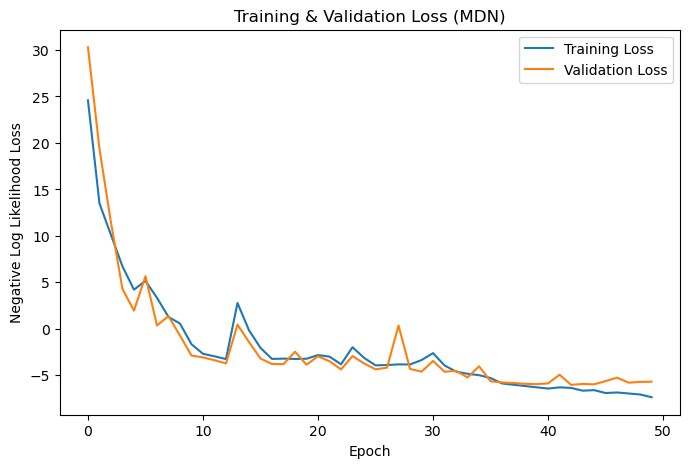

In [34]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = mdn_loss_std(batch_Y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = mdn_loss_std(val_Y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # early stopping
    #if epoch > 5 and val_losses[-1] > min(val_losses[:-1]):
    #    print("Early stopping triggered")
    #    break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < 2:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -5:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -7:
        print("Switching learning rate to 1e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

## Evaluation

In [35]:
def mdn_predict_mean(pi, mu):
    return torch.sum(pi.unsqueeze(-1) * mu, dim=1)  # [B, D]

def mdn_predict_std(pi, mu, sigma):
    # Expected mean: E[y] = sum(pi * mu)
    mean = torch.sum(pi.unsqueeze(2) * mu, dim=1)  # shape: [B, D]

    # Variance: Var[y] = sum(pi * (sigma^2 + (mu - E[y])^2))
    var = torch.sum(
        pi.unsqueeze(2) * (sigma ** 2 + (mu - mean.unsqueeze(1)) ** 2),
        dim=1
    )  # shape: [B, D]

    std = torch.sqrt(var + 1e-8)
    return std

In [36]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]
        y_pred = mdn_predict_mean(pi, mu)       # [B, D]
        y_std = mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())

all_preds = torch.cat(all_preds, dim=0)         # [N, D]
all_targets = torch.cat(all_targets, dim=0)     # [N, D]
all_stds = torch.cat(all_stds, dim=0)           # [N, D]

all_pi = torch.cat(all_pi, dim=0)               # [N, M]
all_mu = torch.cat(all_mu, dim=0)               # [N, M, D]
all_sigma = torch.cat(all_sigma, dim=0)         # [N, M, D]


In [37]:
print(all_preds.shape)
print(all_stds.shape)
print(all_pi.shape)

torch.Size([200, 3])
torch.Size([200, 3])
torch.Size([200, 3])


### Mean absolute error

In [38]:
def compute_mae(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true)).item()

mae = compute_mae(all_preds, all_targets)

print(f"MAE: {mae:.4f}")

MAE: 0.0077


### Take one sample

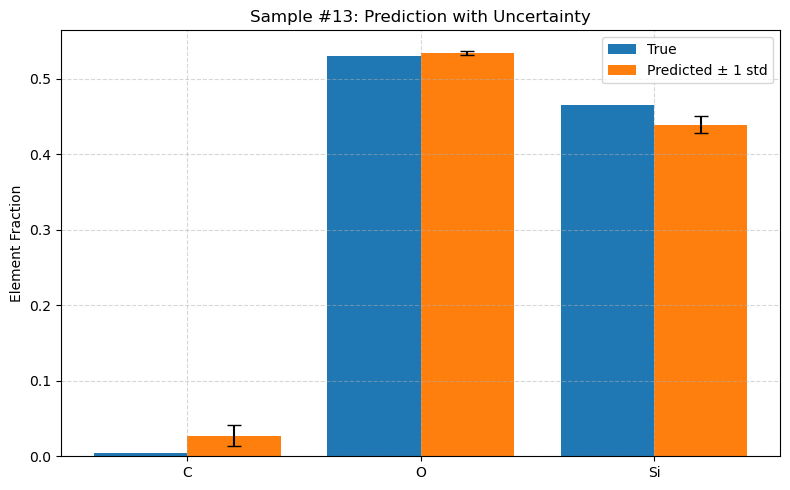

In [39]:
# Take one sample
# To see uncertainty

i = 13
x = torch.arange(len(element_list))

plt.figure(figsize=(8, 5))
plt.bar(x-0.2, all_targets[i], width=0.4, label="True")
plt.bar(x+0.2, all_preds[i], width=0.4, yerr=all_stds[i],
        capsize=5, label="Predicted ± 1 std")

plt.xticks(x, element_list)
plt.ylabel("Element Fraction")
plt.title(f"Sample #{i}: Prediction with Uncertainty")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [40]:
def gaussian_pdf(x, mu, sigma):
    """compute 1D Gaussian PDF."""
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    exponent = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coef * exponent

def plot_mdn_distribution(idx, d, all_pi, all_mu, all_sigma, all_targets):
    """
    idx: sample index
    d: dimension index (e.g. 0 = C, 1 = O, 2 = Si)
    """
    pi = all_pi[idx].numpy()              # [M]
    mu = all_mu[idx, :, d].numpy()        # [M]
    sigma = all_sigma[idx, :, d].numpy()  # [M]
    y_true = all_targets[idx, d].item()

    x = np.linspace(0.0, 0.1, 500)
    pdf = np.zeros_like(x)

    for k in range(len(pi)):
        pdf += pi[k] * gaussian_pdf(x, mu[k], sigma[k])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf, label=f"Predicted PDF for Element {element_list[d]}", color="orange")
    plt.axvline(y_true, color="blue", linestyle="--", label="True Value")
    plt.title(f"Sample #{idx}: MDN Predicted Distribution for Element {element_list[d]}")
    plt.xlabel("Element Fraction")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


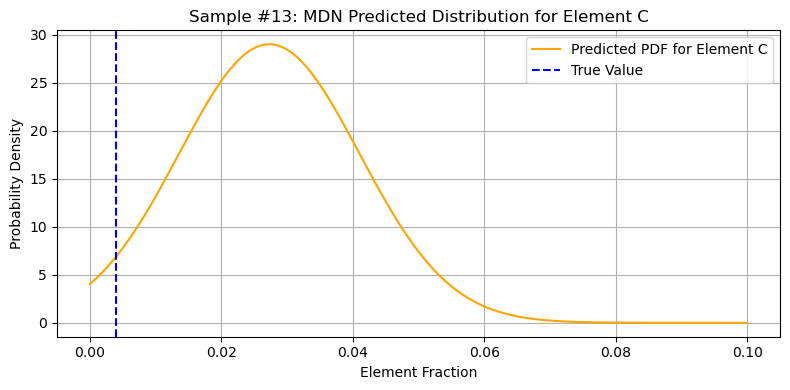

In [41]:
plot_mdn_distribution(idx=13, d=0, 
                      all_pi=all_pi,
                      all_mu=all_mu,
                      all_sigma=all_sigma,
                      all_targets=all_targets)


### Boxplot

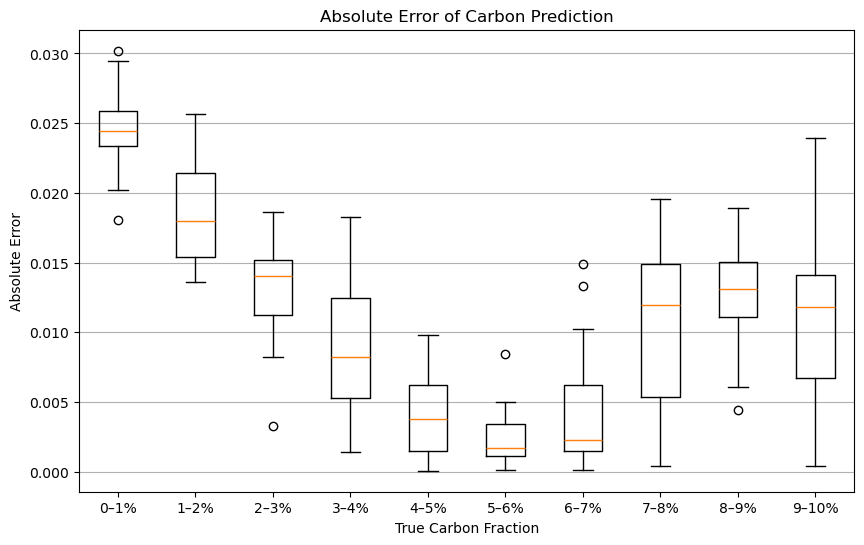

In [42]:
carbon_index = 0
true_C = all_targets[:, carbon_index].numpy()
pred_C = all_preds[:, carbon_index].numpy()
abs_errors = np.abs(true_C - pred_C)

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

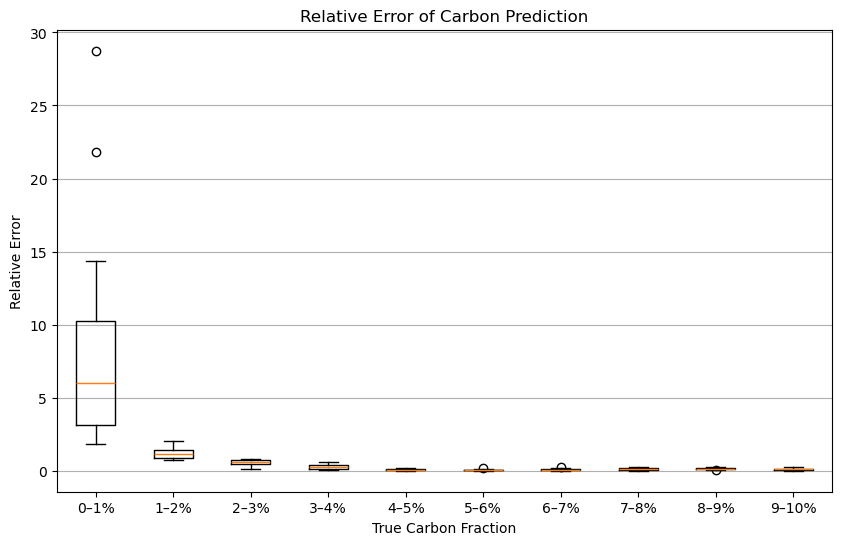

In [43]:
rel_errors = np.abs(true_C - pred_C)/true_C

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect rel error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, rel_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Relative Error")
plt.title("Relative Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

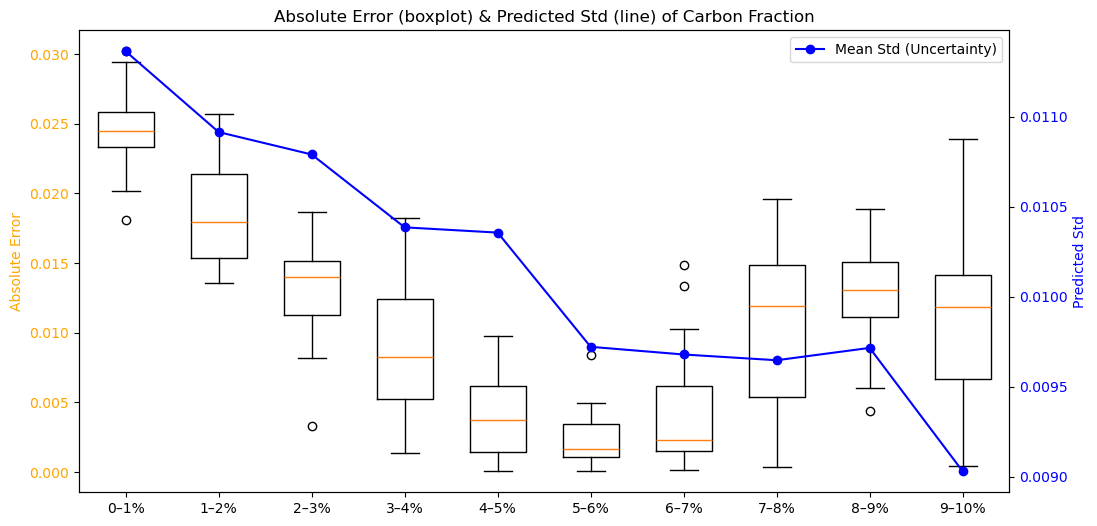

In [44]:
# Add std line plot

std_C = all_stds[:, carbon_index].numpy() 

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]
bin_indices = np.digitize(true_C, bins) - 1  # Bin index: 0 to 9

# Correct abs error and stf in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
grouped_stds = [[] for _ in range(len(bins) - 1)]
for idx, err, std in zip(bin_indices, abs_errors, std_C):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)
        grouped_stds[idx].append(std)

# mean std for each bin
std_means = [np.mean(s) if len(s) > 0 else 0 for s in grouped_stds]
#print(std_means)
x_pos = np.arange(len(bin_labels))

# plot
# left: boxplot; right: std
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplot for abs error
box = ax1.boxplot(grouped_errors, positions=x_pos, widths=0.6)
ax1.set_ylabel("Absolute Error", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# Line plot for std
ax2 = ax1.twinx()
ax2.plot(x_pos, std_means, color="blue", marker="o", label="Mean Std (Uncertainty)")
ax2.set_ylabel("Predicted Std", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

plt.xticks(x_pos, bin_labels)
plt.title("Absolute Error (boxplot) & Predicted Std (line) of Carbon Fraction")
plt.show()

### Residual

In [45]:
residuals = (true_C - pred_C)

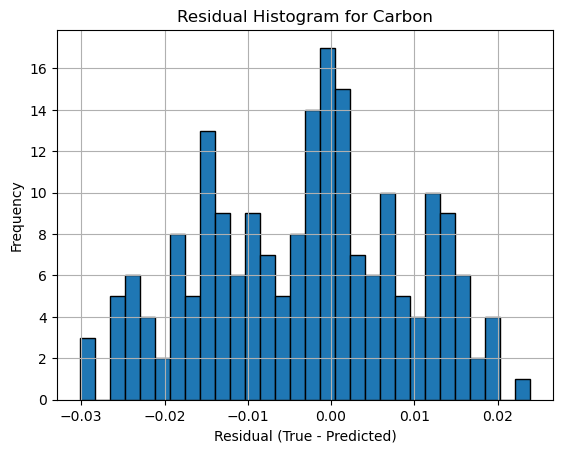

In [46]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Histogram for Carbon")
plt.grid(True)
plt.show()

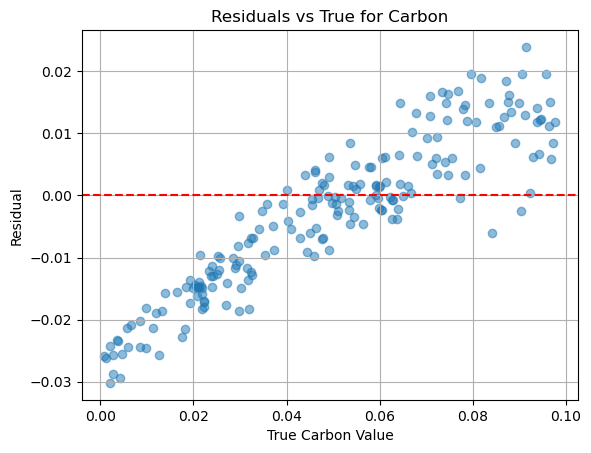

In [47]:
plt.scatter(true_C, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Carbon Value")
plt.ylabel("Residual")
plt.title("Residuals vs True for Carbon")
plt.grid(True)
plt.show()

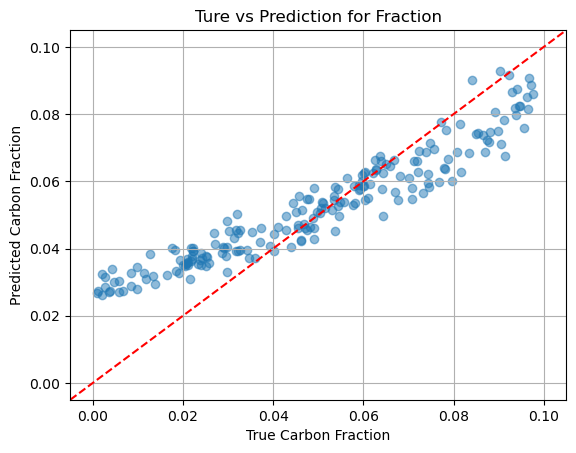

In [48]:
plt.scatter(true_C, pred_C, alpha=0.5)
plt.axline(xy1=(0.1,0.1), xy2=(0,0), color="red", linestyle="--")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Predicted Carbon Fraction")
plt.title("Ture vs Prediction for Fraction")
plt.grid(True)
plt.show()

### Coverage and CI

In [162]:
# [pred-std, pred+std]
lower_bound = pred_C - std_C
upper_bound = pred_C + std_C

# Determine whether within the interval
within = (true_C >= lower_bound) & (true_C <= upper_bound)

# Compute coverage rate
coverage_rate = np.mean(within)
print(f"[Carbon] pred ± 1 std converage：{coverage_rate * 100:.2f}%")

[Carbon] pred ± 1 std converage：69.50%


In [163]:
# 95% CI (mean +- 1.96*std)
# [pred-std, pred+std]
lower_bound = pred_C - 1.96*std_C
upper_bound = pred_C + 1.96*std_C

# Determine whether within the interval
within = (true_C >= lower_bound) & (true_C <= upper_bound)

# Compute coverage rate
coverage_rate = np.mean(within)
print(f"[Carbon] pred ± 1.96 std converage：{coverage_rate * 100:.2f}%")

[Carbon] pred ± 1.96 std converage：96.50%


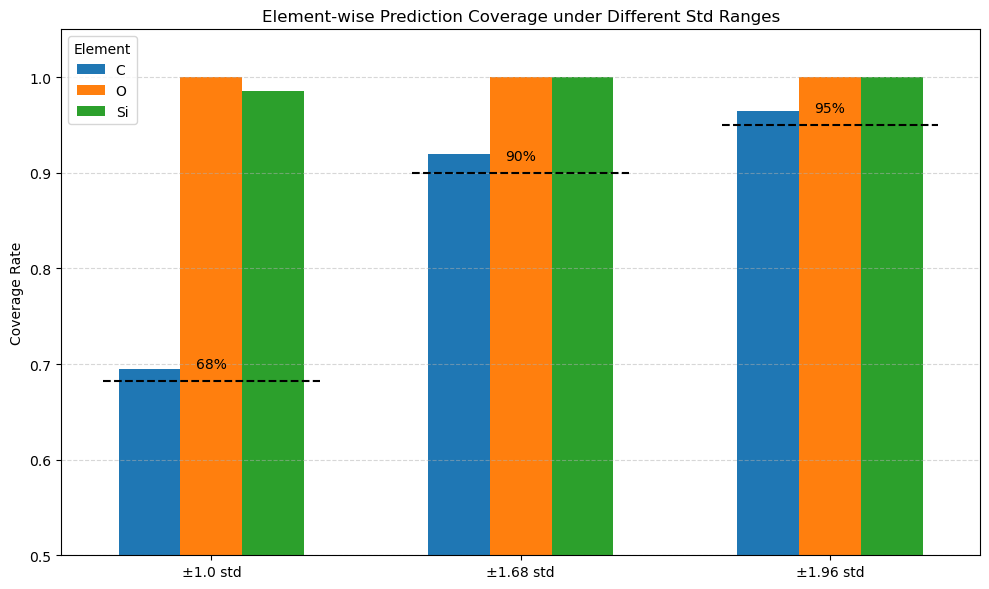

In [164]:
# Set std levels and corresponding CI
std_levels = [1.0, 1.68, 1.96]
theoretical_coverage = [0.6827, 0.90, 0.95]

# Contain coverage rate per element under each std_level
coverage_matrix = []

for std_mult in std_levels:
    element_coverages = []
    for el in element_list:
        idx = element_to_index[el]
        true_vals = all_targets[:, idx].numpy()
        pred_vals = all_preds[:, idx].numpy()
        std_vals = all_stds[:, idx].numpy()

        lower = pred_vals - std_mult * std_vals
        upper = pred_vals + std_mult * std_vals
        within = (true_vals >= lower) & (true_vals <= upper)
        coverage = np.mean(within)
        element_coverages.append(coverage)
    coverage_matrix.append(element_coverages)

coverage_matrix = np.array(coverage_matrix)  # shape: [3 std_levels, 3 elements]

# plot bar
x = np.arange(len(std_levels))  # [0,1,2]
width = 0.2
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(10, 6))
for i, el in enumerate(element_list):
    plt.bar(x + (i - 1) * width, coverage_matrix[:, i], width=width, label=el, color=colors[i])

# Add CI standard lines
for i, (x_pos, ci) in enumerate(zip(x, theoretical_coverage)):
    plt.hlines(ci, x_pos - 0.35, x_pos + 0.35, colors="black", linestyles="dashed")
    plt.text(x_pos, ci + 0.01, f"{int(ci * 100)}%", ha="center", va="bottom", fontsize=10)

plt.xticks(ticks=x, labels=[f"±{s} std" for s in std_levels])
plt.ylabel("Coverage Rate")
plt.ylim(0.5, 1.05)
plt.title("Element-wise Prediction Coverage under Different Std Ranges")
plt.legend(title="Element")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()